# 07 / 08. TP Classification

#### enseignant: Anastasios Giovanidis 2022 - 2023
#### date: 08 / 15 Novembre 2022 

#### student name or binome:

This is the TP related to classification. We will need to import the following libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

In this class we will learn how to use PYTHON for classification, applying the following techniques:

- KNN
- Logistic Regression (multivariate)
- LDA
- QDA

## Preparation: Generating "synthetic" data

Let us first create a reasonable dataset related to $\mathrm{Default}$. The predictors are:

- Balance ('x')
- Income ('z')
- Student[Yes]

There are two classes: 

- Class A: $\mathrm{Default}=Yes$, 
- Class B: $\mathrm{Default}=No$.

We assume that the (balance, income) tuple follows for each class a bi-variate normal distribution
with different mean vector and covariance matrix. 

E.g. for class A: $\mu_A = [\mu_{A}(x),\ \mu_{A}(z)]$,
$\mathbf{\Sigma}_A = \left[\ [Var_A(x,x),Cov_A(x,z)],\  [Cov_A(z,x),Var_A(z,z)] \right]$, and similarly for class B.

In [2]:
muA = [700, 3000]
muB = [1350, 3000]
SigmaA = [[70000,0], [0,900000]]
SigmaB = [[70000,0], [0,900000]]
n = 300 # sample size

The covariance is the same for the two classes.

In [3]:
np.random.seed(100)
xA, zA = np.random.multivariate_normal(muA, SigmaA, n).T
# Avoid negatives
xA = list(np.multiply(xA>0,xA))
zA = list(np.multiply(zA>0,zA))
#
xB, zB = np.random.multivariate_normal(muB, SigmaB, n).T
# Avoid negatives
xB = list(np.multiply(xB>0,xB))
zB = list(np.multiply(zB>0,zB))

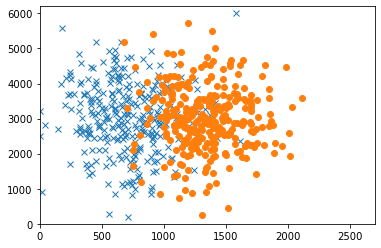

In [4]:
plt.plot(xA, zA, 'x')
plt.plot(xB, zB, 'o')
balanceMAX = 2700
incomeMAX = 6200
plt.axis([-1, balanceMAX, -1, incomeMAX])
plt.show()

Let us plot the histogram for the xA.

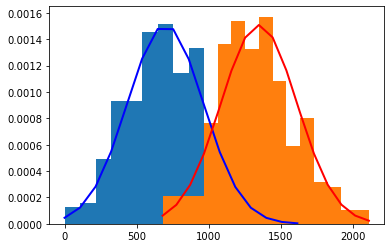

In [5]:
countA, binsA, ignoredA = plt.hist(xA, 15, density=True)
countB, binsB, ignoredB = plt.hist(xB, 15, density=True)
plt.plot(binsA, 1/( np.sqrt(2 * np.pi * SigmaA[0][0])) * np.exp( - (binsA - muA[0])**2 / (2 * SigmaA[0][0]) ), linewidth=2, color='b')
plt.plot(binsB, 1/( np.sqrt(2 * np.pi * SigmaB[0][0])) * np.exp( - (binsB - muB[0])**2 / (2 * SigmaB[0][0]) ), linewidth=2, color='r')
plt.show()

The actual data-trace will look as follows:

In [7]:
x = xA+xB
z = zA+zB
defaultA = list(np.zeros(len(xA)))
defaultB = list(np.ones(len(xB)))
default = defaultA + defaultB
for i in range(len(default)): 
    default[i] = int(default[i]) 

Generate Student[Yes] predictor. We give a higher probability for someone with high $x$ (Balance) to be a student, because we assume that students tend to borrow money from a bank for their studies (tendency for higher balance).

In [8]:
Student = list()
Mx = max(x)
for i in range(len(x)):
    p = x[i]/max(x)/2
    Student.extend(np.random.binomial(1, p, 1))
#

In [9]:
# Percentage of students in the data set
muS = sum(Student)/len(Student)

In [10]:
print(muS)

0.23666666666666666


Create a Dictionary of DATA

In [11]:
DATA = {}
for i in range(len(x)):
    DATA[i] = {}
    DATA[i]['predictors'] = [x[i],z[i],Student[i]]
    DATA[i]['Default'] = default[i]

In [12]:
print(DATA[1])

{'predictors': [633.2117025413584, 4093.865807946399, 0], 'Default': 0}


or put everything in a pandas structure:

In [13]:
import pandas as pd
data1 = {'balance': x, 'income': z, 'student[Yes]': Student , 'y-Default[Yes]': default}
df_DATA = pd.DataFrame(data=data1)
df_DATA

,balance,income,student[Yes],y-Default[Yes]
0,790.664713,1340.026720,0,0
1,633.211703,4093.865808,0,0
2,836.049517,3930.962641,0,0
3,416.893146,3209.829458,1,0
4,767.467041,2820.228470,0,0
...,...,...,...,...
595,1255.148641,2372.074801,0,1
596,1375.892328,2932.481878,0,1
597,1539.465139,4679.803405,0,1
598,1791.358794,2760.898896,1,1


## Exercise 1 (KNN)

Use the K-Nearest-Neighbours classification method, to build a $\mathrm{Default}=\left\{Yes,No\right\}$ classifier, based on the DATA available. For the moment you can ignore the $\mathrm{Student}$ predictor, and only use the pair of predictors $(\mathrm{Balance},\mathrm{Income})$.

### Part A

For $K=1,3,10,40$

- Train the KNN classifier using the entire data-set (no train-test split).
- Plot a 2D map of the areas where $\mathrm{Default}=Yes$.

Discuss your observations.

### Part B

- Using the function **from sklearn.model_selection import cross_validate** do a cross-validation for the DATA set (balance, income) and estimate the Test Classification error for each $K$. Then average over all the ways that the set was split to derive the average Test error per $K$. Use as scores: **scoring=('accuracy', 'roc_auc','neg_mean_absolute_error')** and plot the mean scores over $1/K$.  What is your conclusion about the optimal $K$ value among the values you checked? Take **$K=1,\ldots, 100$**.

I want to see 3 plots, in each plot two curves, one for Train and the other for Test. The x-axis should be in logarithmic scale. The y-axis in linear scale.

**Answer: (Part A)**

First create input vector X01 containing only the 0 and 1 entry of each vector.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

**Answer: (Part B)**

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import SCORERS
Kmax = 100
Train_accuracy = list()
Test_accuracy = list()
Train_roc = list()
Test_roc = list()
Train_error = list()
Test_error = list()
#
for K in range(1,Kmax):
    neigh = KNeighborsClassifier(n_neighbors=K)
    #TODO...

In [15]:
#To check the SCORERS do:
#print(SCORERS.keys())

In [16]:
#To check the keys for cross validats scores, print the keys()
#print(cv_results.keys())

In [17]:
#print(cv_results['test_roc_auc'])

The best fitting value for K-NN is for $K=$...

## Exercise 2 (Logistic Regression)

- Split the original data set into a train and a test set, so that Test-set is 30\% of the whole Data entries. Use the Logistic Regression classifier, to derive the prediction for the first entry of the $Xtest$ set.

Use **logistic.predict(X_test[0])** and **logistic.predict_proba([X_test[0]])**. What do you observe?

Use **logreg.score(X_test,D_test)** to find the mean prediction error.

- Split in several ways the original data set into train-test sets. For each, calculate the error, and the average over all ways. What is the value of the Test error rate in Logistic Regression (averaged over all splits)? Compare with the error rate from the optimal KNN classifier above. What do you see?

- Use the confusion matrix of the last split to evaluate the correctness of the predictor for the last Train-Test split. Find the Accuracy (ACC), True-Positive rate (TPR), False-Positive rate (FPR) and the Precision (PPV). 

- Repeat the whole processes using Cross Validation (**cross_validate**)

In [18]:
from sklearn.linear_model import LogisticRegression

The Logistic coefficients for the last Train-Test split are as follows:

In [19]:
#print('logreg1.classes_ =', logreg1.classes_)
#print('logreg1.coef_ =', logreg1.coef_) #b1 and b2 coefficients
#print('logreg1.intercept_ =', logreg1.intercept_) #b0 coefficient

Compare the logistic regression score with the mean accuracy. What do you observe?

In [20]:
#logreg.score(X_test,Y_test)
#np.sum(np.abs(logreg.predict(X_test) - Y_test))/len(Y_test)

We can also see the confusion matrix with False/True Positives/Negatives.

In [21]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(D_test, D_esti)
print('confusion_matrix=\n', CM)
# x-axis is Known Truth, y-axis is Prediction.

NameError: name 'D_test' is not defined

In [128]:
TE = (CM[1][0]+CM[0][1])/(CM[0][0]+CM[0][1]+CM[1][0]+CM[1][1])
print('Latest Test-Set Total Error= %.3f' %TE)

Latest Test-Set Total Error= 0.133


In [15]:
FPR = 0#TODO
print('Latest Test-Set False Positive= %.3f' %FP)
TPR = 0#TODO
print('Latest Test-Set True Positive= %.3f' %TP)
ACC = 0#TODO
PPV = 0#TODO

Latest Test-Set False Positive= 0.000
Latest Test-Set True Positive= 0.000


Using Cross Validation

In [19]:
Logi_Train_accuracy = list()
Logi_Test_accuracy = list()
Logi_Train_roc = list()
Logi_Test_roc = list()
Logi_Train_error = list()
Logi_Test_error = list()
#
logregCV = LogisticRegression()
# TODO
#
print('Test_error =', Logi_Test_error)
print('Test ROC curve surface =', Logi_Test_roc)
print('Test accuracy =', Logi_Test_accuracy)
#print('logregCV.coef_ =', logregCV.coef_)

Test_error = []
Test ROC curve surface = []
Test accuracy = []


## Exercise 3 (Discriminant Analysis LDA & QDA)

- Use the $\mathrm{LinearDiscriminantAnalysis}$ (LDA) and $\mathrm{QuadraticDiscriminantAnalysis}$ (QDA) method to fit the Train Data and predict the Test Data.

- Again find the average Test Error using several Train-Test splits.

- Compare the Average Test Error for LDA, QDA, Logistic and KNN. Order the methods for the specific dataset.

**Answer:**

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis

## Exercise 4 (Uniform) -- Bonus*

Generate again an artificial dataset where the (Balance,Income) tuple is generated from two independent uniform distributions. The ranges are:

- Class A (no Default): Income is $[100,6000]$ and the range of Balance is $[10,1500]$, number of samples 300.

- Class B (yes Default): Income is $[100,6000]$ and the range of Balance is $[1000,2500]$, number of samples 100.

(A) Find the Accuracy and the Mean Test Error using Cross Validation, for K-NN ($K=1,\ldots,100$), Logistic Regression, LDA, QDA.

(B) Order the methods by their quality. Which one is better? Why?

**Answer:**

We first generate the uniform "synthetic" data.

In [25]:
nA = 300 # sample size per class
nB = 120

In [26]:
zA = np.random.uniform(100,6000,nA)
xA = np.random.uniform(10, 1500,nA)
#
zB = np.random.uniform(100,6000,nB)
xB = np.random.uniform(1000,2500,nB)

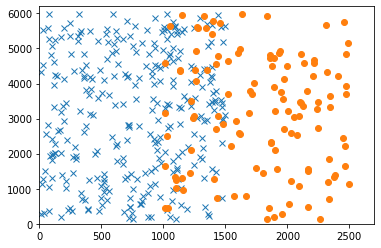

In [27]:
plt.plot(xA, zA, 'x')
plt.plot(xB, zB, 'o')
balanceMAX = 2700
incomeMAX = 6200
plt.axis([-1, balanceMAX, -1, incomeMAX])
plt.show()

In [28]:
x = list(xA)+list(xB)
z = list(zA)+list(zB)
defUA = list(np.zeros(len(xA)))
defUB = list(np.ones(len(xB)))
defU = defUA + defUB
for i in range(len(defU)): 
    defU[i] = int(defU[i]) 

In [29]:
XU01 = list()
for i in range(len(defU)):
    XU01.append([x[i],z[i]])

## Exercise 5 (Class related covariance matrix $\Sigma_m$) 

Generate again an artificial dataset where the (Balance,Income) tuple is generated from a binormal distribution. The data from the two classes have different means and covariances for their predictors:

In [31]:
muSA = [700, 3000]
muSB = [1350, 3000]
SigmaSA = [[70000,-100], [-100,900000]]
SigmaSB = [[70000,+200], [+200,900000]]
nS = 300 # sample size

In [35]:
xSA, zSA = np.random.multivariate_normal(muSA, SigmaSA, nS).T
# Avoid negatives
xSA = list(np.multiply(xSA>0,xSA))
zSA = list(np.multiply(zSA>0,zSA))
#
xSB, zSB = np.random.multivariate_normal(muSB, SigmaSB, nS).T
# Avoid negatives
xSB = list(np.multiply(xB>0,xB))
zSB = list(np.multiply(zB>0,yB))

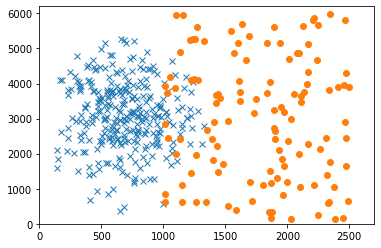

In [36]:
plt.plot(xSA, zSA, 'x')
plt.plot(xSB, zSB, 'o')
balanceMAX = 2700
incomeMAX = 6200
plt.axis([-1, balanceMAX, -1, incomeMAX])
plt.show()

In [37]:
xS = xSA+xSB
zS = zSA+zSB
defaultSA = list(np.zeros(len(xSA)))
defaultSB = list(np.ones(len(xSB)))
defaultS = defaultSA + defaultSB
for i in range(len(defaultS)): 
    defaultS[i] = int(defaultS[i])

In [38]:
XUS01 = list()
for i in range(len(defaultS)):
    XUS01.append([xS[i],zS[i]])

(A) Find the Accuracy and the Mean Test Error Rate (using the average of several Train-Test splits) for all the above methods (K-NN ($K=1,\ldots,100$), Logistic Regression, LDA, QDA).

(B) Order the methods by their quality. Which one is better? Why?

## Exercise 6 (non-linear predictors) 

Generate again an artificial dataset where the (Balance,Income) tuple is generated from two Normal distributions as the first dataset. You can also use non-zero covariance between the variables.

Then, suppose that the values of (Balance, Income) are not observed, but rather the triplet of predictors: 

($\mathrm{Balance^2},\mathrm{Income^2}, \mathrm{Balance\times Income}$).

(A) Find the Mean Test Error Rate (using the average of several Train-Test splits) for all the above methods and specifically: 1NN, 3NN, 10NN, LR, LDA, QDA.

(B) Order the methods by their quality. Which one is better? Why?